In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from scipy import stats

In [2]:
sp500 = pd.read_csv('S&P500 Daily Returns.csv')

sp500['RET'] = pd.to_numeric(sp500['RET'], errors='coerce')
sp500['RETX'] = pd.to_numeric(sp500['RETX'], errors='coerce')
sp500.head(10)

C:\Users\joel3\AppData\Local\Temp\ipykernel_6716\3551061304.py:1: DtypeWarning: Columns (10,13) have mixed types. Specify dtype option on import or set low_memory=False.
  sp500 = pd.read_csv('S&P500 Daily Returns.csv')


,PERMNO,date,SICCD,TICKER,COMNAM,HSICIG,BIDLO,ASKHI,PRC,VOL,RET,SHROUT,NUMTRD,RETX,sprtrn,enterdate,positive,negative,total,market_cap
0,10104,2023-01-03,7372.0,ORCL,ORACLE CORP,NaN,82.260,83.8400,83.72,8997534.0,0.024223,2696253.0,NaN,0.024223,-0.004001,NaN,0.0,0.0,0.0,2.257303e+08
1,10104,2023-01-04,7372.0,ORCL,ORACLE CORP,NaN,83.640,85.1700,84.48,7836238.0,0.009078,2696253.0,NaN,0.009078,0.007539,NaN,0.0,0.0,0.0,2.277795e+08
2,10104,2023-01-05,7372.0,ORCL,ORACLE CORP,NaN,83.220,85.4000,84.31,7643784.0,-0.002012,2696253.0,NaN,-0.002012,-0.011646,NaN,0.0,0.0,0.0,2.273211e+08
3,10104,2023-01-06,7372.0,ORCL,ORACLE CORP,NaN,83.820,86.3400,85.66,8641597.0,0.016012,2696253.0,NaN,0.016012,0.022841,NaN,0.0,0.0,0.0,2.309610e+08
4,10104,2023-01-09,7372.0,ORCL,ORACLE CORP,NaN,86.160,87.5900,86.42,7519836.0,0.012608,2696253.0,NaN,0.008872,-0.000768,NaN,0.0,0.0,0.0,2.330102e+08
5,10104,2023-01-10,7372.0,ORCL,ORACLE CORP,NaN,85.570,86.6100,86.50,5703270.0,0.000926,2696253.0,NaN,0.000926,0.006978,NaN,0.0,0.0,0.0,2.332259e+08
6,10104,2023-01-11,7372.0,ORCL,ORACLE CORP,NaN,87.090,88.6600,88.60,8359667.0,0.024277,2696253.0,NaN,0.024277,0.012849,NaN,0.0,0.0,0.0,2.388880e+08
7,10104,2023-01-12,7372.0,ORCL,ORACLE CORP,NaN,88.170,89.1950,88.78,6071099.0,0.002032,2696253.0,NaN,0.002032,0.003416,2023-01-12,1.0,0.0,1.0,2.393733e+08
8,10104,2023-01-13,7372.0,ORCL,ORACLE CORP,NaN,87.660,89.4662,89.20,5090938.0,0.004731,2696253.0,NaN,0.004731,0.003997,NaN,0.0,0.0,0.0,2.405058e+08
9,10104,2023-01-17,7372.0,ORCL,ORACLE CORP,NaN,88.425,89.4400,88.60,6550412.0,-0.006726,2696253.0,NaN,-0.006726,-0.002030,2023-01-17,0.0,0.0,1.0,2.388880e+08


              SICCD    market_cap        SHROUT           VOL            PRC  \
count  25816.000000  2.581600e+04  2.581600e+04  2.581600e+04   25816.000000   
mean    5202.610745  7.143520e+07  6.505627e+05  4.982809e+06     704.329767   
std     2291.694404  1.918577e+08  1.247295e+06  1.103751e+07   11453.068356   
min      721.000000  1.037917e+06  3.179000e+03  1.187200e+04       3.520000   
25%     3571.000000  1.572950e+07  1.398740e+05  9.414228e+05      62.491375   
50%     4925.000000  2.828674e+07  2.839020e+05  1.937771e+06     109.733000   
75%     7011.000000  5.656227e+07  6.096150e+05  4.528681e+06     208.721498   
max     9999.000000  3.061528e+09  1.584117e+07  2.245165e+08  280125.338999   

               ASKHI         BIDLO         total      negative      positive  \
count   25816.000000  25816.000000  25816.000000  25816.000000  25816.000000   
mean     1241.020233    185.969800      1.522234      0.012047      0.185234   
std     23295.656099    353.840774     

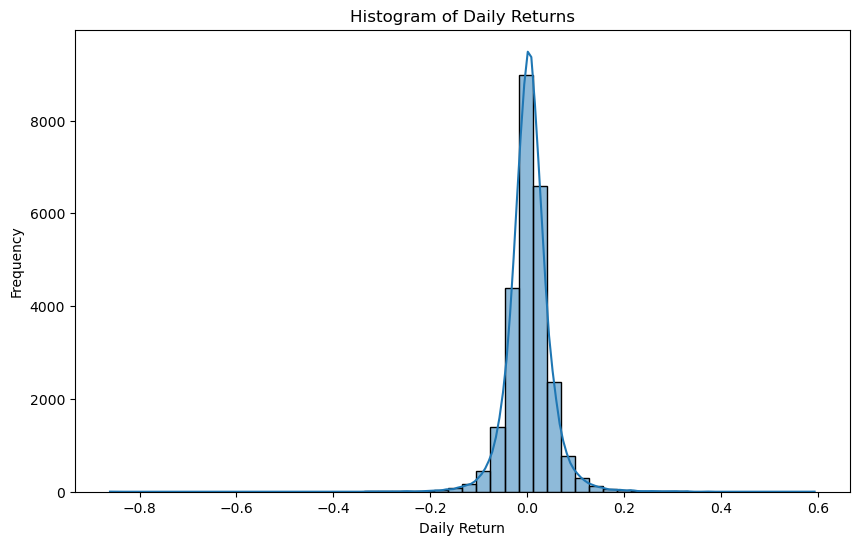

In [3]:
# Change date format
sp500['date'] = pd.to_datetime(sp500['date'], format='%Y-%m-%d')

# Remove the columns HSICIG and enterdate
sp500.drop(columns=['HSICIG', 'enterdate', 'NUMTRD'], inplace=True)

# Reset index
sp500.reset_index(drop=True, inplace=True)


# Group by week and ticker and perform aggregations
agg_columns = {
    'SICCD': 'first',
    'COMNAM': 'first',
    'market_cap': 'mean',
    'SHROUT': 'mean',
    'VOL': 'mean',
    'PRC': 'mean',
    'ASKHI': 'max',
    'BIDLO': 'min',
    'total': 'sum',
    'negative': 'sum',
    'positive': 'sum',
    'sprtrn': lambda x: (1 + x).prod() - 1,
    'RET': lambda x: (1 + x).prod() - 1
}

# Group by 'TICKER' and resample the data to weekly frequency
sp500 = sp500.groupby('TICKER').resample('W-MON', on='date').agg(agg_columns).reset_index()

# Adding lagged columns
sp500['next_week_return'] = sp500.groupby('TICKER')['RET'].shift(-1)
sp500['last_week_return'] = sp500.groupby('TICKER')['RET'].shift(1)
sp500['last_week_volume'] = sp500.groupby('TICKER')['VOL'].shift(1)

# Add columns for moving averages
sp500['2_week_ma'] = sp500.groupby('TICKER')['PRC'].rolling(window=2).mean().reset_index(drop=True)
sp500['3_week_ma'] = sp500.groupby('TICKER')['PRC'].rolling(window=3).mean().reset_index(drop=True)
sp500['4_week_ma'] = sp500.groupby('TICKER')['PRC'].rolling(window=4).mean().reset_index(drop=True)

# Create "proper?" column
sp500['proper?'] = (sp500['2_week_ma'] > sp500['3_week_ma']) & (sp500['3_week_ma'] > sp500['4_week_ma']).astype(int)

# Create price minus 
sp500['Ask_minus_Bid'] = sp500['ASKHI'] - sp500['BIDLO']

# Create comp_size column
sp500['comp_size'] = pd.qcut(sp500['market_cap'], q=10, labels=False)

# Display summary statistics
print(sp500.describe())

# Plot histogram of returns
plt.figure(figsize=(10, 6))
sns.histplot(data=sp500, x='RET', bins=50, kde=True)
plt.title('Histogram of Daily Returns')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.show()


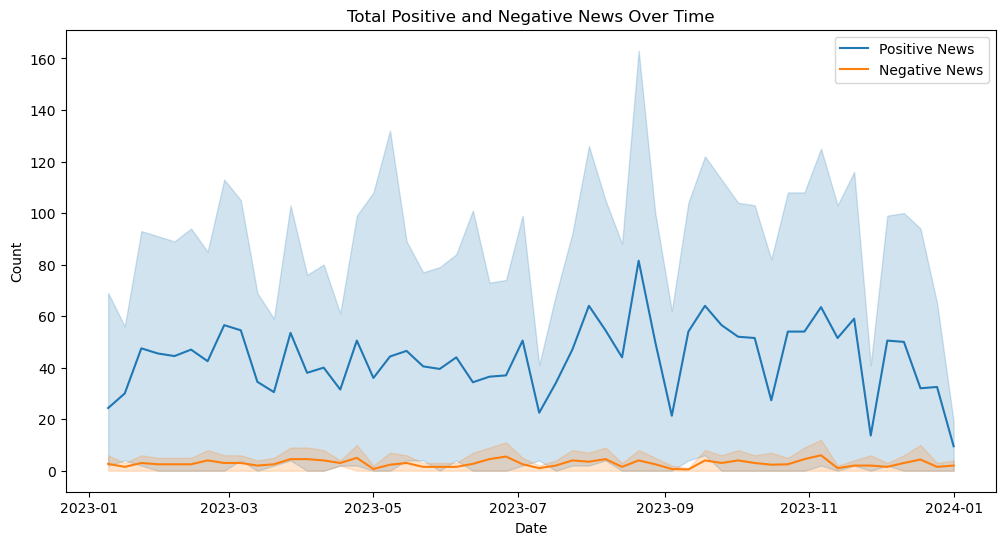

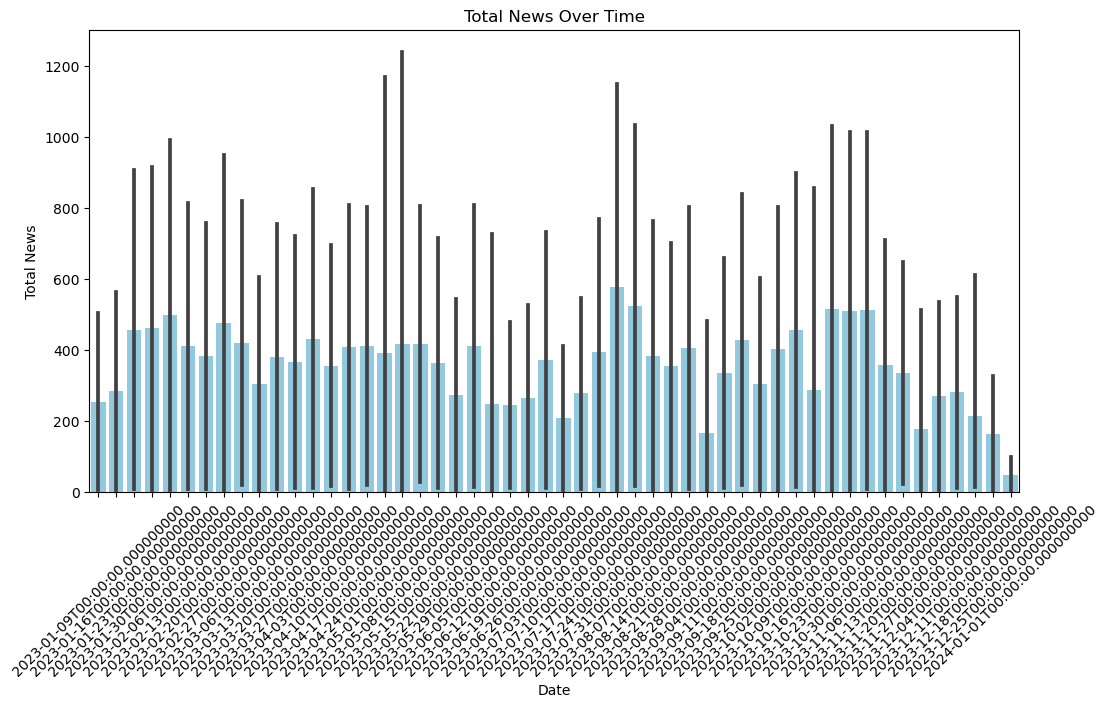

In [4]:
# Daily aggregation
daily_summary = sp500.groupby(['date', 'sprtrn']).agg(
    sum_positive=('positive', 'sum'),
    sum_negative=('negative', 'sum'),
    sum_total=('total', 'sum')
).reset_index()

# Plot line chart of total positive and negative news over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_summary, x='date', y='sum_positive', label='Positive News')
sns.lineplot(data=daily_summary, x='date', y='sum_negative', label='Negative News')
plt.title('Total Positive and Negative News Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.show()

# Plot bar chart of total news over time
plt.figure(figsize=(12, 6))
sns.barplot(data=daily_summary, x='date', y='sum_total', color='skyblue')
plt.title('Total News Over Time')
plt.xlabel('Date')
plt.ylabel('Total News')
plt.xticks(rotation=45)
plt.show()

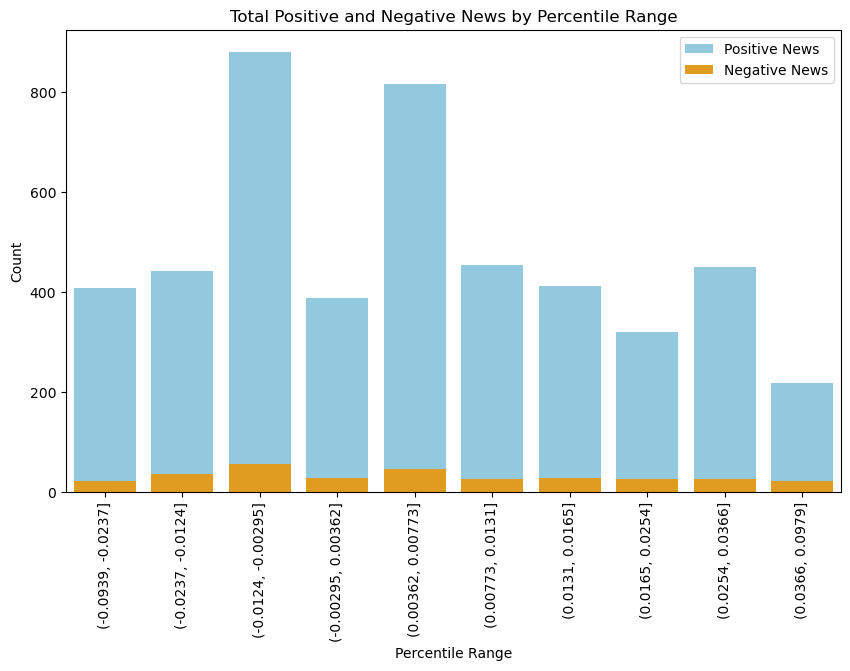

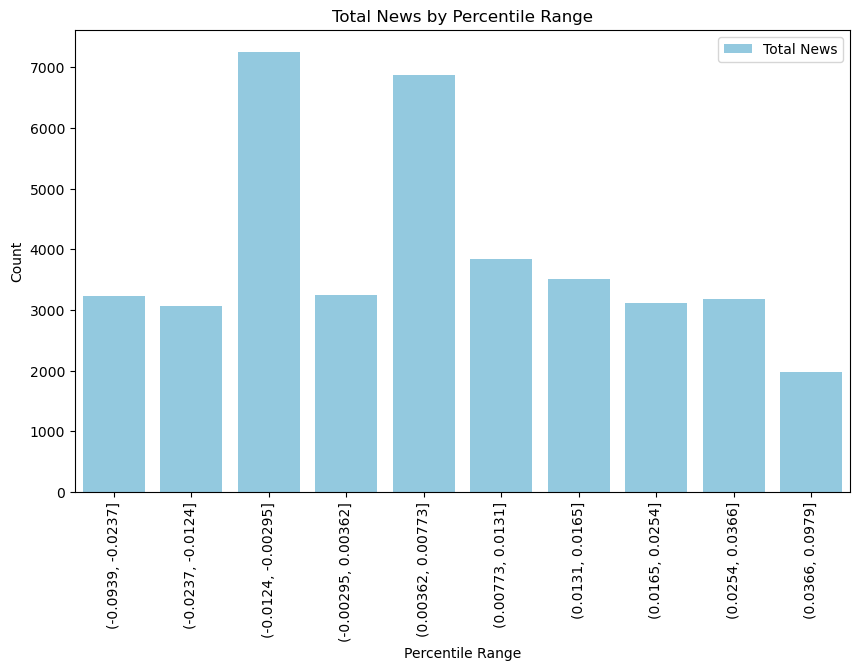

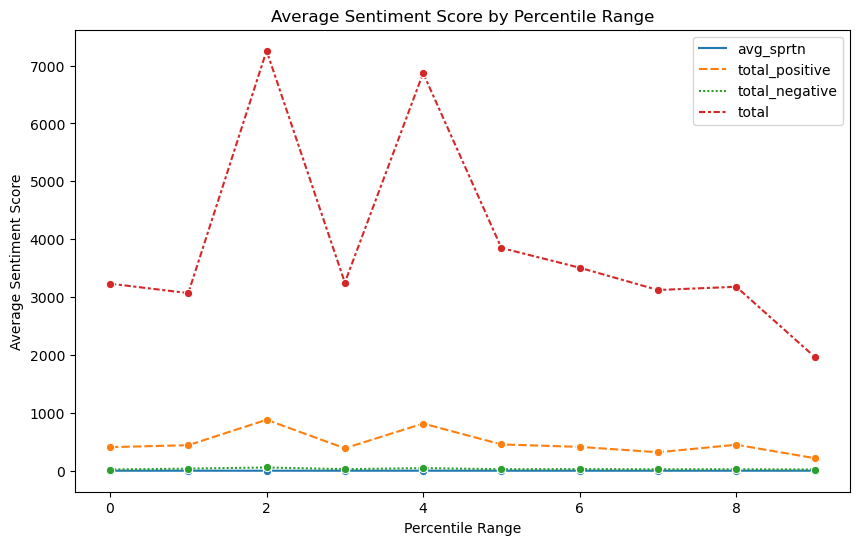

In [5]:
# Percentile summary
ranked_sprtrn = daily_summary.copy()
ranked_sprtrn['sprtrn_percentile'] = pd.qcut(ranked_sprtrn['sprtrn'], q=10, labels=False)
ranked_sprtrn['percentile_range'] = pd.qcut(ranked_sprtrn['sprtrn'], q=10)

percentile_summary = ranked_sprtrn.groupby('percentile_range').agg(
    avg_sprtn=('sprtrn', 'mean'),
    total_positive=('sum_positive', 'sum'),
    total_negative=('sum_negative', 'sum'),
    total=('sum_total', 'sum')
).reset_index()

# Plot bar chart of total positive and negative news by percentile range
plt.figure(figsize=(10, 6))
sns.barplot(data=percentile_summary, x='percentile_range', y='total_positive', color='skyblue', label='Positive News')
sns.barplot(data=percentile_summary, x='percentile_range', y='total_negative', color='orange', label='Negative News')
plt.title('Total Positive and Negative News by Percentile Range')
plt.xlabel('Percentile Range')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate x-axis labels by 90 degrees
plt.legend()
plt.show()

# Plot bar chart of total positive and negative news by percentile range
plt.figure(figsize=(10, 6))
sns.barplot(data=percentile_summary, x='percentile_range', y='total', color='skyblue', label='Total News')
plt.title('Total News by Percentile Range')
plt.xlabel('Percentile Range')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate x-axis labels by 90 degrees
plt.legend()
plt.show()

# Plot line chart of average sentiment score by percentile range
plt.figure(figsize=(10, 6))
sns.lineplot(data=percentile_summary.drop(columns='percentile_range'), marker='o', color='green')
plt.title('Average Sentiment Score by Percentile Range')
plt.xlabel('Percentile Range')
plt.ylabel('Average Sentiment Score')
plt.show()


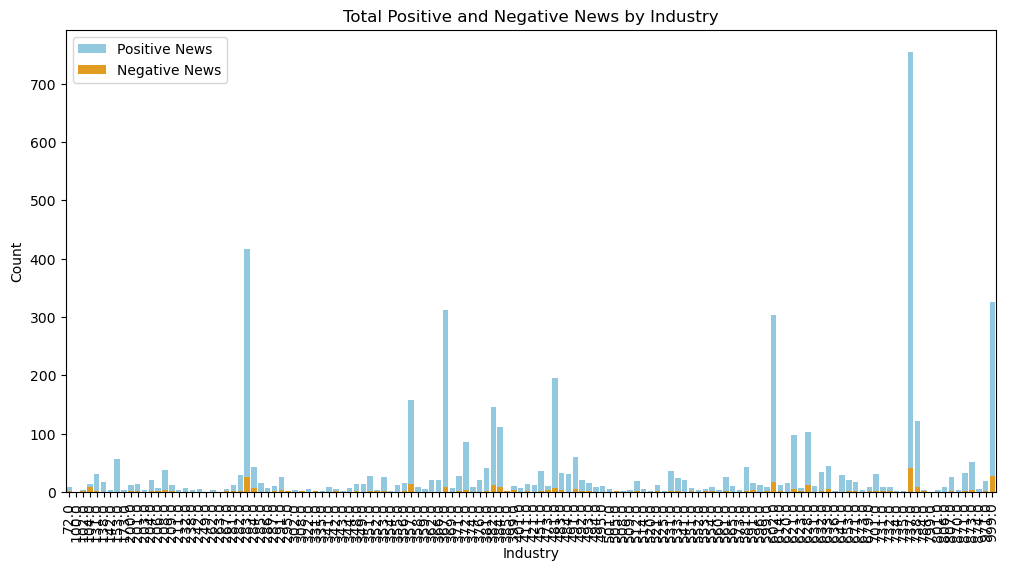

In [6]:
# Industry summary
industry_summary = sp500.groupby(sp500['SICCD'] // 10).agg(
    num_firms=('TICKER', 'nunique'),
    cum_ret=('RET', 'sum'),
    total_positive=('positive', 'sum'),
    total_negative=('negative', 'sum'),
    total=('total', 'sum')
).reset_index()

industry_summary['positive_perc'] = industry_summary['total_positive'] / industry_summary['total']
industry_summary['negative_perc'] = industry_summary['total_negative'] / industry_summary['total']

# Plot bar chart of total positive and negative news by industry
plt.figure(figsize=(12, 6))
sns.barplot(data=industry_summary, x='SICCD', y='total_positive', color='skyblue', label='Positive News')
sns.barplot(data=industry_summary, x='SICCD', y='total_negative', color='orange', label='Negative News')
plt.title('Total Positive and Negative News by Industry')
plt.xlabel('Industry')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate x-axis labels by 90 degrees
plt.legend()
plt.show()


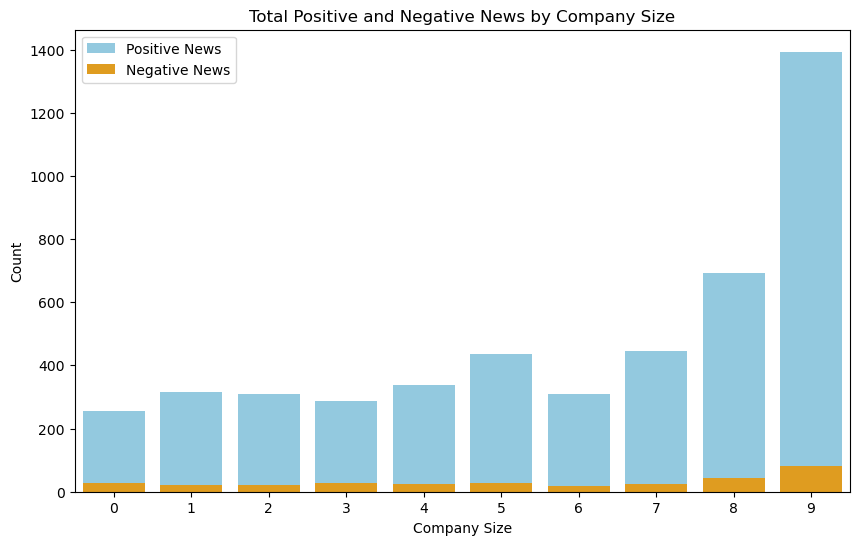

In [7]:
# Company size summary
stock_size = sp500.copy()
stock_size['comp_size'] = pd.qcut(stock_size['market_cap'], q=10, labels=False)
company_size_summary = stock_size.groupby('comp_size').agg(
    sum_ret=('RET', 'sum'),
    total_positive=('positive', 'sum'),
    total_negative=('negative', 'sum'),
    total=('total', 'sum')
).reset_index()

company_size_summary['positive_perc'] = company_size_summary['total_positive'] / company_size_summary['total']
company_size_summary['negative_perc'] = company_size_summary['total_negative'] / company_size_summary['total']

# Plot bar chart of total positive and negative news by company size
plt.figure(figsize=(10, 6))
sns.barplot(data=company_size_summary, x='comp_size', y='total_positive', color='skyblue', label='Positive News')
sns.barplot(data=company_size_summary, x='comp_size', y='total_negative', color='orange', label='Negative News')
plt.title('Total Positive and Negative News by Company Size')
plt.xlabel('Company Size')
plt.ylabel('Count')
plt.legend()
plt.show()


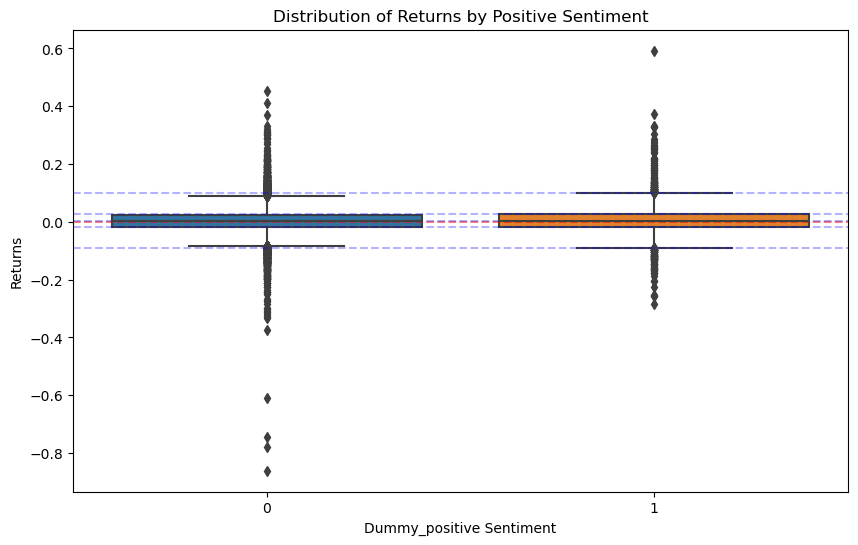

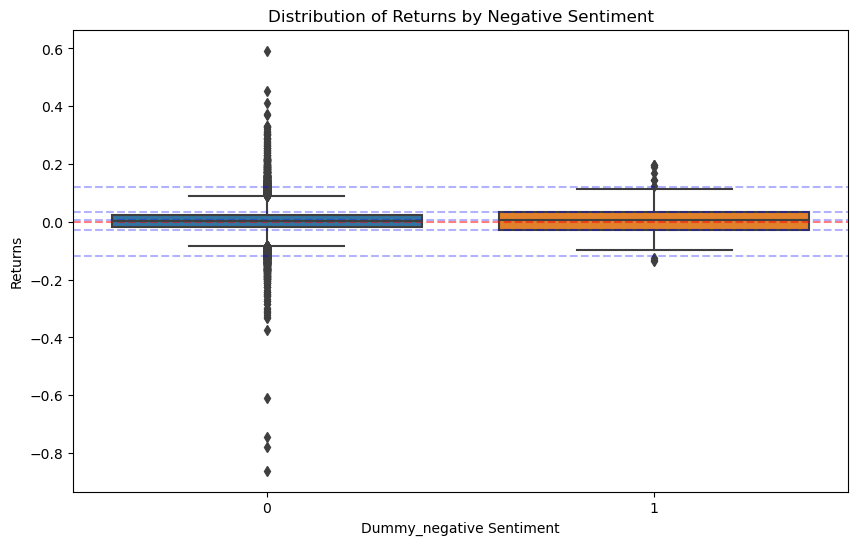

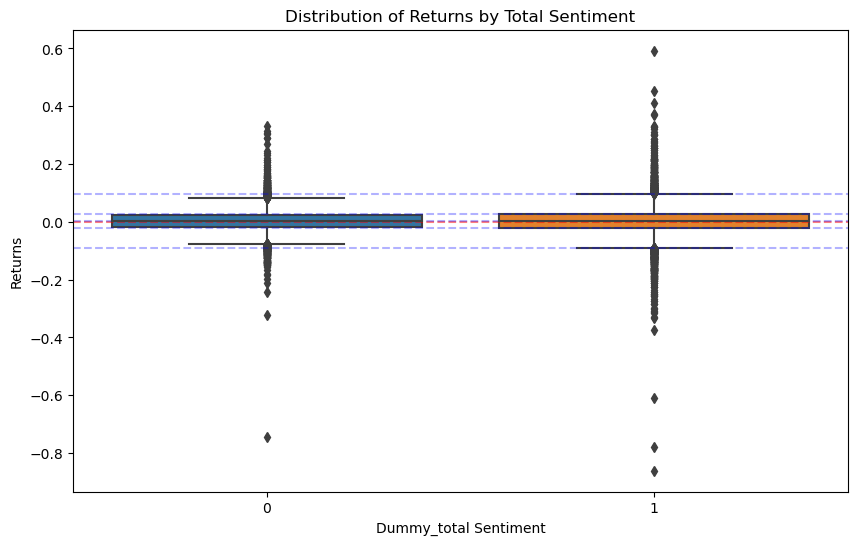

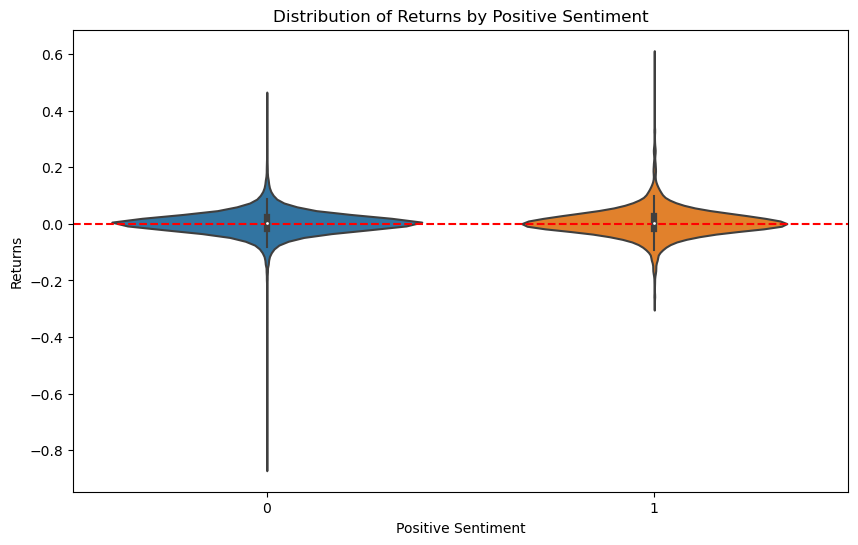

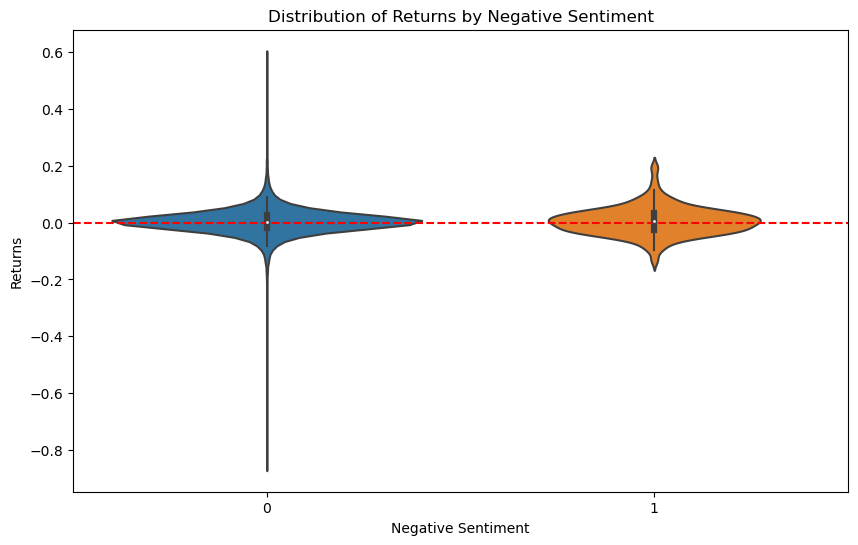

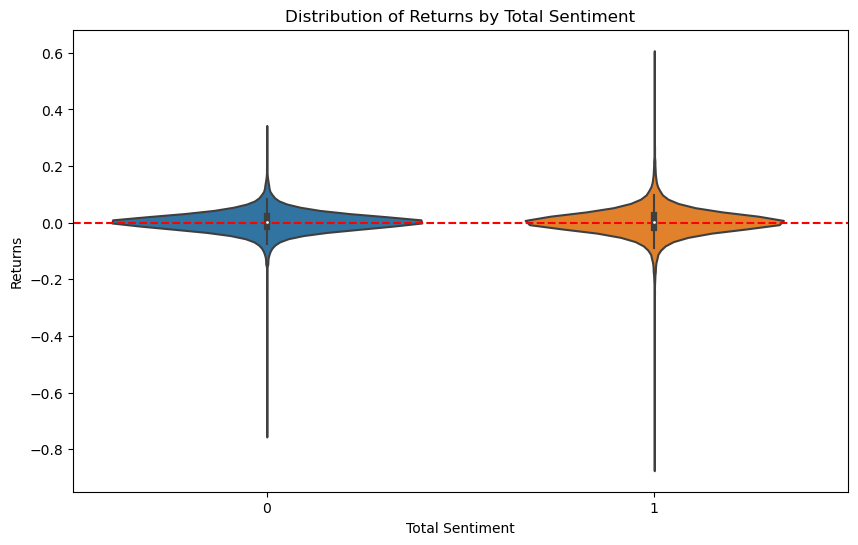

In [8]:
# Create dummy_negative column
sp500['dummy_negative'] = (sp500['negative'] >= 1).astype(int)

# Create dummy_positive column
sp500['dummy_positive'] = (sp500['positive'] >= 1).astype(int)

# Create dummy_total column
sp500['dummy_total'] = (sp500['total'] >= 1).astype(int)


# Function to plot with additional lines
def plot_with_lines(data, x_col, y_col, title):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=x_col, y=y_col, data=data)
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    # Add blue dashed lines for critical points of value >= 1 category
    for i, box in enumerate(data.groupby(x_col)[y_col]):
        if box[0] == 1:
            quartiles = box[1].quantile([0.25, 0.5, 0.75])
            plt.axhline(y=quartiles[0.25], color='blue', linestyle='--', alpha=0.3)
            plt.axhline(y=quartiles[0.5], color='blue', linestyle='--', alpha=0.3)
            plt.axhline(y=quartiles[0.75], color='blue', linestyle='--', alpha=0.3)              
            iqr = quartiles[0.75] - quartiles[0.25]
            upper_limit = 1.5 * iqr + quartiles[0.75]
            lower_limit = quartiles[0.25] - 1.5 * iqr
            # Add additional blue dashed lines
            plt.axhline(y=upper_limit, color='blue', linestyle='--', alpha=0.3)  # Upper limit
            plt.axhline(y=lower_limit, color='blue', linestyle='--', alpha=0.3)  # Lower limit
    plt.title(title)
    plt.xlabel(x_col.capitalize() + ' Sentiment')
    plt.ylabel('Returns')
    plt.show()


# Box plot for dummy_positive
plot_with_lines(sp500, 'dummy_positive', 'RET', 'Distribution of Returns by Positive Sentiment')

# Box plot for dummy_negative
plot_with_lines(sp500, 'dummy_negative', 'RET', 'Distribution of Returns by Negative Sentiment')

# Box plot for dummy_total
plot_with_lines(sp500, 'dummy_total', 'RET', 'Distribution of Returns by Total Sentiment')

# Violin plot for dummy_positive
plt.figure(figsize=(10, 6))
sns.violinplot(x='dummy_positive', y='RET', data=sp500)
plt.axhline(y=0, color='red', linestyle='--') 
plt.title('Distribution of Returns by Positive Sentiment')
plt.xlabel('Positive Sentiment')
plt.ylabel('Returns')
plt.show()

# Violin plot for dummy_negative
plt.figure(figsize=(10, 6))
sns.violinplot(x='dummy_negative', y='RET', data=sp500)
plt.axhline(y=0, color='red', linestyle='--') 
plt.title('Distribution of Returns by Negative Sentiment')
plt.xlabel('Negative Sentiment')
plt.ylabel('Returns')
plt.show()

# Violin plot for dummy_total
plt.figure(figsize=(10, 6))
sns.violinplot(x='dummy_total', y='RET', data=sp500)
plt.axhline(y=0, color='red', linestyle='--') 
plt.title('Distribution of Returns by Total Sentiment')
plt.xlabel('Total Sentiment')
plt.ylabel('Returns')
plt.show()


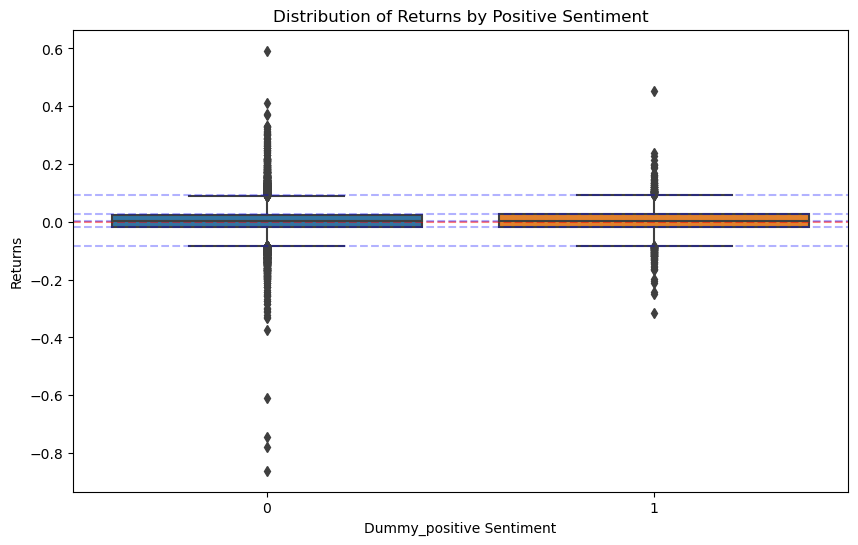

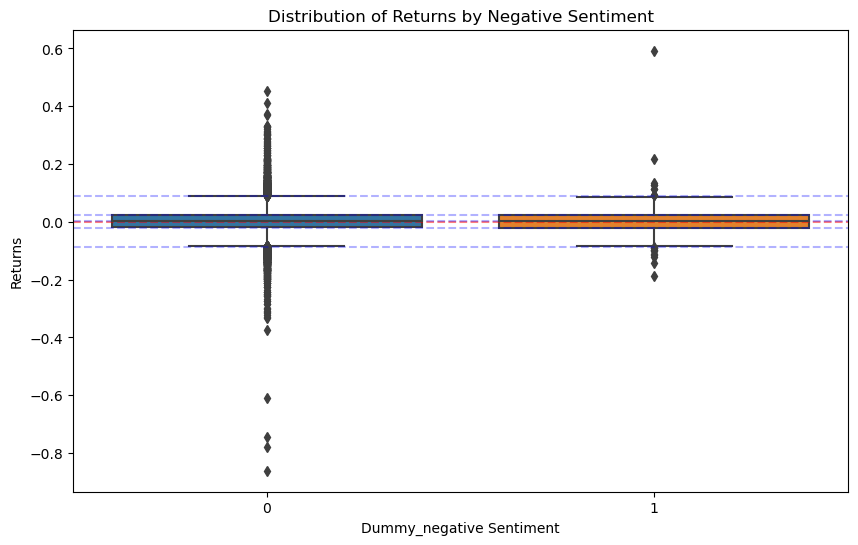

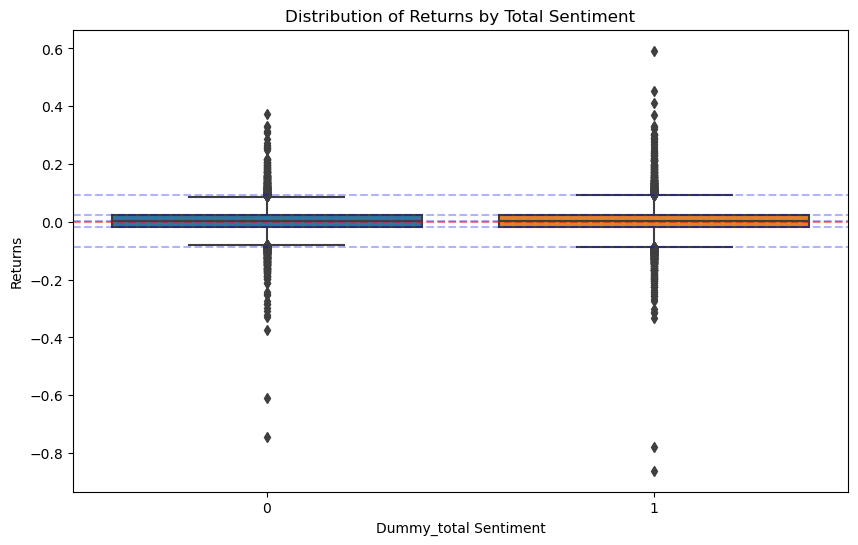

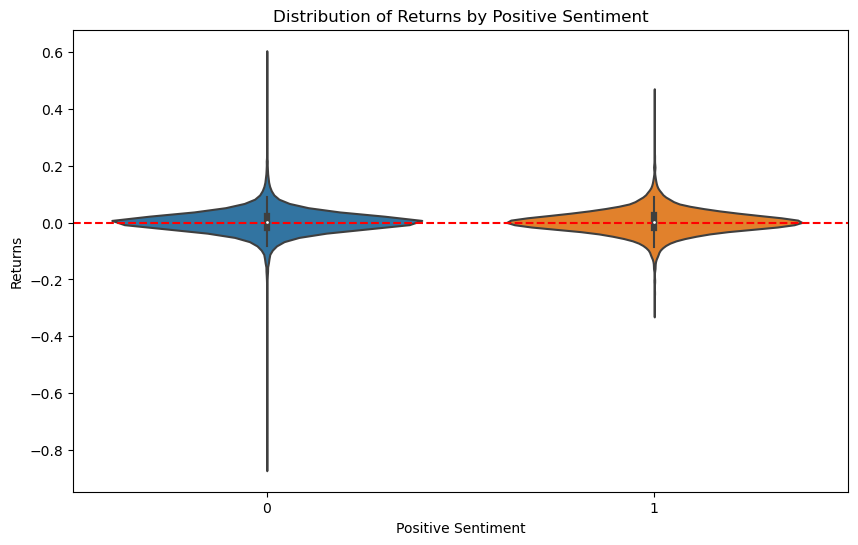

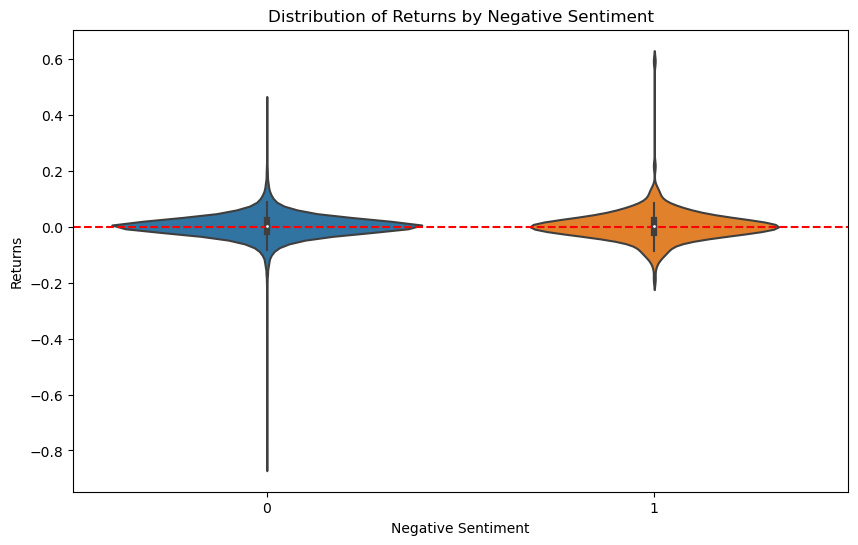

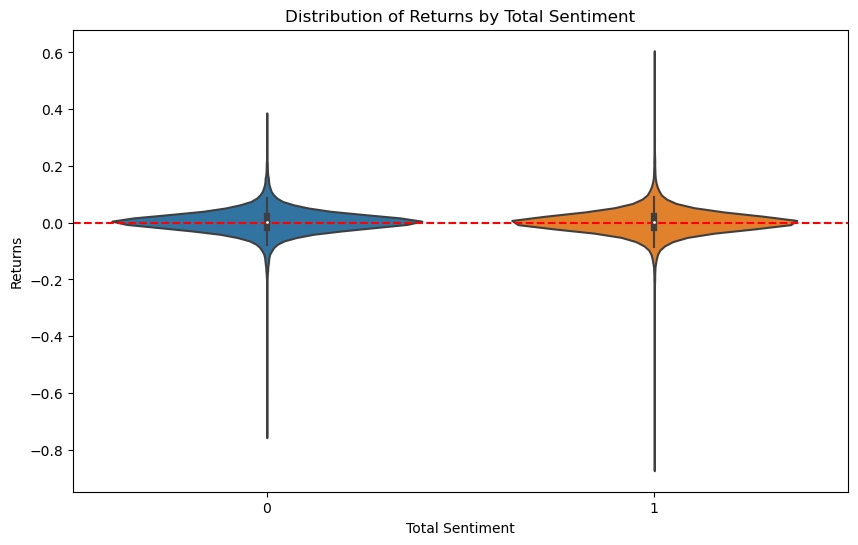

In [9]:
# Box plot for dummy_positive
plot_with_lines(sp500, 'dummy_positive', 'next_week_return', 'Distribution of Returns by Positive Sentiment')

# Box plot for dummy_negative
plot_with_lines(sp500, 'dummy_negative', 'next_week_return', 'Distribution of Returns by Negative Sentiment')

# Box plot for dummy_total
plot_with_lines(sp500, 'dummy_total', 'next_week_return', 'Distribution of Returns by Total Sentiment')

# Violin plot for dummy_positive
plt.figure(figsize=(10, 6))
sns.violinplot(x='dummy_positive', y='next_week_return', data=sp500)
plt.axhline(y=0, color='red', linestyle='--') 
plt.title('Distribution of Returns by Positive Sentiment')
plt.xlabel('Positive Sentiment')
plt.ylabel('Returns')
plt.show()

# Violin plot for dummy_negative
plt.figure(figsize=(10, 6))
sns.violinplot(x='dummy_negative', y='next_week_return', data=sp500)
plt.axhline(y=0, color='red', linestyle='--') 
plt.title('Distribution of Returns by Negative Sentiment')
plt.xlabel('Negative Sentiment')
plt.ylabel('Returns')
plt.show()

# Violin plot for dummy_total
plt.figure(figsize=(10, 6))
sns.violinplot(x='dummy_total', y='next_week_return', data=sp500)
plt.axhline(y=0, color='red', linestyle='--') 
plt.title('Distribution of Returns by Total Sentiment')
plt.xlabel('Total Sentiment')
plt.ylabel('Returns')
plt.show()

In [10]:
from scipy.stats import ttest_ind, mannwhitneyu

# Define a function to remove outliers using Z-score
def remove_outliers(df, column, threshold=3):
    z_scores = (df[column] - df[column].mean()) / df[column].std()
    df_filtered = df[(z_scores.abs() < threshold)]
    return df_filtered

# Remove outliers from the sp500 DataFrame
sp500 = remove_outliers(sp500, 'Ask_minus_Bid')
sp500 = remove_outliers(sp500, 'VOL')
sp500.to_csv('weekly_sp500_regression.csv', index=False)

# Calculate mean and standard deviation (volatility) for each combination of dummy variables
mean_negative = sp500[sp500['dummy_negative'] == 1]['Ask_minus_Bid'].mean()
std_negative = sp500[sp500['dummy_negative'] == 1]['Ask_minus_Bid'].std()

mean_positive = sp500[sp500['dummy_positive'] == 1]['Ask_minus_Bid'].mean()
std_positive = sp500[sp500['dummy_positive'] == 1]['Ask_minus_Bid'].std()

mean_total = sp500[sp500['dummy_total'] == 1]['Ask_minus_Bid'].mean()
std_total = sp500[sp500['dummy_total'] == 1]['Ask_minus_Bid'].std()

# Calculate mean and standard deviation (volatility) when the dummy variables are equal to zero
mean_negative_zero = sp500[sp500['dummy_negative'] == 0]['Ask_minus_Bid'].mean()
std_negative_zero = sp500[sp500['dummy_negative'] == 0]['Ask_minus_Bid'].std()

mean_positive_zero = sp500[sp500['dummy_positive'] == 0]['Ask_minus_Bid'].mean()
std_positive_zero = sp500[sp500['dummy_positive'] == 0]['Ask_minus_Bid'].std()

mean_total_zero = sp500[sp500['dummy_total'] == 0]['Ask_minus_Bid'].mean()
std_total_zero = sp500[sp500['dummy_total'] == 0]['Ask_minus_Bid'].std()

# t-test for mean difference
t_statistic_mean_negative, p_value_mean_negative = ttest_ind(sp500[sp500['dummy_negative'] == 1]['Ask_minus_Bid'],
                                                             sp500[sp500['dummy_negative'] == 0]['Ask_minus_Bid'])

t_statistic_mean_positive, p_value_mean_positive = ttest_ind(sp500[sp500['dummy_positive'] == 1]['Ask_minus_Bid'],
                                                             sp500[sp500['dummy_positive'] == 0]['Ask_minus_Bid'])

t_statistic_mean_total, p_value_mean_total = ttest_ind(sp500[sp500['dummy_total'] == 1]['Ask_minus_Bid'],
                                                       sp500[sp500['dummy_total'] == 0]['Ask_minus_Bid'])

# Mann-Whitney U test for difference in volatility
u_statistic_vol_negative, p_value_vol_negative = mannwhitneyu(sp500[sp500['dummy_negative'] == 1]['Ask_minus_Bid'],
                                                              sp500[sp500['dummy_negative'] == 0]['Ask_minus_Bid'])

u_statistic_vol_positive, p_value_vol_positive = mannwhitneyu(sp500[sp500['dummy_positive'] == 1]['Ask_minus_Bid'],
                                                              sp500[sp500['dummy_positive'] == 0]['Ask_minus_Bid'])

u_statistic_vol_total, p_value_vol_total = mannwhitneyu(sp500[sp500['dummy_total'] == 1]['Ask_minus_Bid'],
                                                        sp500[sp500['dummy_total'] == 0]['Ask_minus_Bid'])

# Create a DataFrame to display the results
data = {
    'Dummy': ['Negative', 'Positive', 'Total'],
    'Mean_with_Dummy': [mean_negative, mean_positive, mean_total],
    'Mean_without_Dummy': [mean_negative_zero, mean_positive_zero, mean_total_zero],
    'Volatility_with_Dummy': [std_negative, std_positive, std_total],
    'Volatility_without_Dummy': [std_negative_zero, std_positive_zero, std_total_zero],
    'Mean_Difference': [mean_negative - mean_negative_zero,
                        mean_positive - mean_positive_zero,
                        mean_total - mean_total_zero],
    'Volatility_Difference': [std_negative - std_negative_zero,
                              std_positive - std_positive_zero,
                              std_total - std_total_zero],
    'Mean_P_value': [p_value_mean_negative, p_value_mean_positive, p_value_mean_total],
    'Volatility_P_value': [p_value_vol_negative, p_value_vol_positive, p_value_vol_total]
}
df_results = pd.DataFrame(data)

# Display the results
print(df_results)

      Dummy  Mean_with_Dummy  Mean_without_Dummy  Volatility_with_Dummy  \
0  Negative        11.451222           10.729638              16.712773   
1  Positive        10.989404           10.697211              16.787057   
2     Total        10.782288           10.680717              18.118235   

   Volatility_without_Dummy  Mean_Difference  Volatility_Difference  \
0                 21.082262         0.721584              -4.369489   
1                 21.639018         0.292193              -4.851961   
2                 24.211422         0.101571              -6.093187   

   Mean_P_value  Volatility_P_value  
0      0.578677        3.291605e-02  
1      0.448130        1.204932e-10  
2      0.703110        1.307549e-28  


In [11]:
# Specify the columns for which to calculate z-scores
columns_to_standardize = ['BIDLO', 'ASKHI', 'PRC', 'VOL', 'RET', 'SHROUT', 'sprtrn', 'market_cap', 'last_week_return', '2_week_ma', '3_week_ma', 
                          '4_week_ma', 'Ask_minus_Bid', 'last_week_volume']

# Group by ticker and standardize each group for specified columns
sp500_grouped = sp500.groupby('TICKER')[columns_to_standardize]

# Define a function to standardize values within each group
def standardize_group(group):
    group_std = (group - group.mean()) / group.std()
    return group_std

# Apply the standardization function to each group
sp500_standardized = sp500_grouped.transform(standardize_group)

# Replace original values with standardized values in the original DataFrame
sp500[columns_to_standardize] = sp500_standardized

# Check the modified DataFrame
print(sp500.head())

  TICKER       date   SICCD                    COMNAM  market_cap    SHROUT  \
0      A 2023-01-09  3825.0  AGILENT TECHNOLOGIES INC    1.521682  0.867158   
1      A 2023-01-16  3825.0  AGILENT TECHNOLOGIES INC    1.998631  0.867158   
2      A 2023-01-23  3825.0  AGILENT TECHNOLOGIES INC    1.913152  0.867158   
3      A 2023-01-30  3825.0  AGILENT TECHNOLOGIES INC    1.882646  0.867158   
4      A 2023-02-06  3825.0  AGILENT TECHNOLOGIES INC    1.809625  0.867158   

        VOL       PRC     ASKHI     BIDLO  ...  last_week_volume  2_week_ma  \
0 -0.376345  1.514475  1.611440  1.305345  ...               NaN        NaN   
1 -1.171945  1.999800  1.886507  1.711812  ...         -0.407192   1.804736   
2 -1.035157  1.912820  1.955272  1.951868  ...         -1.210345   2.006697   
3 -1.498350  1.881778  1.880254  1.862643  ...         -1.072259   1.946860   
4 -0.740216  1.807475  1.796901  1.815199  ...         -1.539849   1.893450   

   3_week_ma  4_week_ma  proper?  Ask_minus_Bid  c

Kurtosis:
BIDLO              -0.501872
ASKHI              -0.592103
PRC                -0.578143
VOL                 4.180431
RET                 1.603351
SHROUT             -0.493010
sprtrn              0.474540
market_cap         -0.573432
last_week_return    1.540942
2_week_ma          -0.614377
3_week_ma          -0.641761
4_week_ma          -0.676243
Ask_minus_Bid       4.257491
last_week_volume    4.463793
dtype: float64

Skewness:
BIDLO               0.096955
ASKHI               0.123439
PRC                 0.113584
VOL                 1.622422
RET                -0.100849
SHROUT             -0.046715
sprtrn             -0.332774
market_cap          0.124327
last_week_return   -0.069116
2_week_ma           0.115320
3_week_ma           0.109963
4_week_ma           0.100164
Ask_minus_Bid       1.656758
last_week_volume    1.710906
dtype: float64


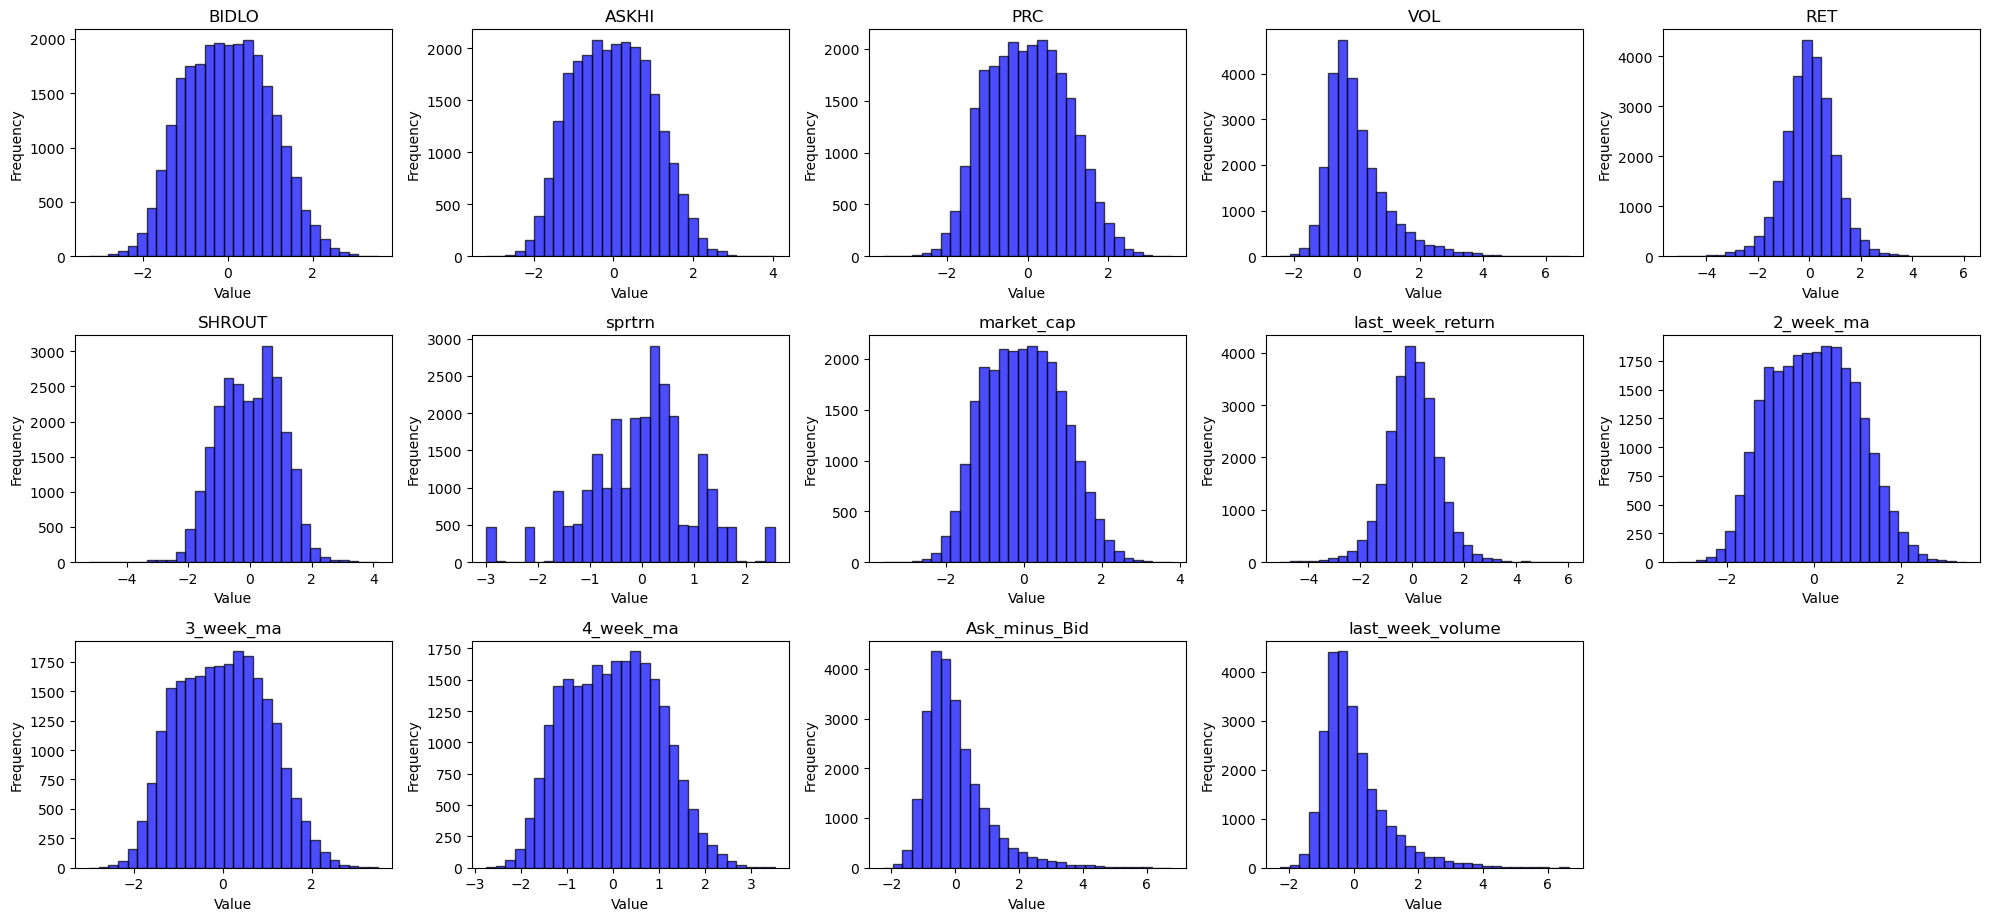

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate kurtosis and skewness for each numeric variable
numeric_columns = ['BIDLO', 'ASKHI', 'PRC', 'VOL', 'RET', 'SHROUT', 'sprtrn', 'market_cap', 'last_week_return', 
                   '2_week_ma', '3_week_ma', '4_week_ma', 'Ask_minus_Bid', 'last_week_volume']
kurtosis_values = sp500[numeric_columns].kurtosis()
skewness_values = sp500[numeric_columns].skew()

# Print kurtosis and skewness values for each numeric variable
print("Kurtosis:")
print(kurtosis_values)
print("\nSkewness:")
print(skewness_values)

# Plot histograms for each numeric variable
plt.figure(figsize=(20, 15))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(5, 5, i)
    plt.hist(sp500[col], bins=30, color='blue', edgecolor='black', alpha=0.7)
    plt.title(col)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [13]:
sp500.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25254 entries, 0 to 25815
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   TICKER            25254 non-null  object        
 1   date              25254 non-null  datetime64[ns]
 2   SICCD             25254 non-null  float64       
 3   COMNAM            25254 non-null  object        
 4   market_cap        25253 non-null  float64       
 5   SHROUT            25134 non-null  float64       
 6   VOL               25253 non-null  float64       
 7   PRC               25253 non-null  float64       
 8   ASKHI             25253 non-null  float64       
 9   BIDLO             25253 non-null  float64       
 10  total             25254 non-null  float64       
 11  negative          25254 non-null  float64       
 12  positive          25254 non-null  float64       
 13  sprtrn            25253 non-null  float64       
 14  RET               2525

In [14]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector as selector

# Convert specified columns to categorical
sp500['SICCD'] = sp500['SICCD'].astype('category')
sp500['comp_size'] = sp500['comp_size'].astype('category')
sp500['proper?'] = sp500['proper?'].astype('category')
sp500['dummy_negative'] = sp500['dummy_negative'].astype('category')
sp500['dummy_positive'] = sp500['dummy_positive'].astype('category')
sp500['dummy_total'] = sp500['dummy_total'].astype('category')

sp500.to_csv('standardized_weekly_sp500_regression.csv', index=False)
sp500_clean = sp500.dropna()

# Select features and target variable
features = sp500_clean.drop(columns=['tomorrow_return', 'TICKER', 'COMNAM', 'date'])
target = sp500_clean['tomorrow_return']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Define preprocessing steps for numerical and categorical features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, selector(dtype_exclude="object")),
        ('cat', categorical_transformer, selector(dtype_include="object"))
    ])

# Define LassoCV model
lasso_cv = LassoCV(cv=5, random_state=42)

# Create pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('lasso', lasso_cv)])

# Fit the model
pipeline.fit(X_train, y_train)

# Print the best alpha
print("Best alpha:", pipeline.named_steps['lasso'].alpha_)

# Print the R^2 score
print("R^2 score:", pipeline.score(X_test, y_test))

# Access the model coefficients
model_coefs = pipeline.named_steps['lasso'].coef_
print("Model coefficients:", model_coefs)

KeyError: "['tomorrow_return'] not found in axis"

In [ ]:
sp500 = sp500.dropna()

# Add a new column 'pred_lasso' to the sp500 dataframe with predictions
sp500['pred_lasso'] = pipeline.predict(sp500.drop(columns=['tomorrow_return', 'TICKER', 'COMNAM', 'date']))

# Display the first few rows of the dataframe to verify the new column
print(sp500.head())

plt.hist(sp500['pred_lasso'], bins=30, color='blue', edgecolor='black', alpha=0.7)
plt.title('Predicted Lasso Distribution')
plt.xlabel('Predicted Lasso Returns')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Define RandomForestRegressor model
rf_model = RandomForestRegressor(random_state=12)

# Create pipeline
pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor),
                              ('random_forest', rf_model)])

# Define parameter grid
param_grid = {
    'random_forest__n_estimators': [50, 100],
    'random_forest__max_depth': [None, 10],
    'random_forest__min_samples_split': [2, 5],
    'random_forest__min_samples_leaf': [1, 2]
}

# Perform grid search with reduced parameters and folds
grid_search = GridSearchCV(pipeline_rf, param_grid, cv=3, scoring='r2')
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters:", grid_search.best_params_)

# Print the best R^2 score
print("Best R^2 score:", grid_search.best_score_)

# Get the best model
best_model = grid_search.best_estimator_

# Evaluate the best model on the test set
test_score = best_model.score(X_test, y_test)
print("Test set R^2 score of the best model:", test_score)
